In [1]:
# Установка необходимых библиотек (если не установлены)
!pip install chembl_webresource_client pandas rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.5 MB/s eta 0:00:00


In [2]:
from chembl_webresource_client.new_client import new_client
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import rdFingerprintGenerator

from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score

In [3]:
# 1. Подключение к базе данных ChEMBL
activity = new_client.activity
target = new_client.target

Фактор некроза опухоли альфа (TNF-α) — ключевой медиатор воспаления и клеточной гибели, играющий важную роль в аутоиммунных заболеваниях, таких как ревматоидный артрит, псориаз и болезнь Крона. Ингибирование TNF-α используется в биологической терапии для подавления избыточного воспалительного ответа. Предполагаю, что для этого интерлейкине(широко изученного) будет достаточно информации по мишеням и лигандам.

In [4]:
# Поиск мишени: TNF-α (человеческий TNF-alpha)
# Используем поиск по ключевому слову "TNF-alpha" и фильтр по организму "Homo sapiens"
targets = target.filter(pref_name__icontains="Tumor necrosis factor", organism="Homo sapiens")
target_df = pd.DataFrame.from_dict(targets)

In [5]:
# Выводим найденные мишени для проверки
print("Найденные мишени:")
print(target_df[['target_chembl_id', 'pref_name']])

Найденные мишени:
   target_chembl_id                                          pref_name
0        CHEMBL3378                  Tumor necrosis factor receptor R1
1        CHEMBL5714  Tumor necrosis factor ligand superfamily member 6
2        CHEMBL5813  Tumor necrosis factor ligand superfamily membe...
3     CHEMBL1075153  Tumor necrosis factor receptor superfamily mem...
4     CHEMBL1250356  Tumor necrosis factor receptor superfamily mem...
5     CHEMBL1250358  Tumor necrosis factor receptor superfamily mem...
6     CHEMBL1250360  Tumor necrosis factor receptor superfamily mem...
7     CHEMBL1250376  Tumor necrosis factor receptor superfamily mem...
8     CHEMBL2364158  Tumor necrosis factor ligand superfamily membe...
9     CHEMBL2364161  Tumor necrosis factor receptor superfamily mem...
10    CHEMBL2364162  Tumor necrosis factor ligand superfamily membe...
11    CHEMBL3712850  Tumor necrosis factor receptor superfamily mem...
12    CHEMBL3712857  Tumor necrosis factor receptor superfa

In [6]:
# Выбираем первую мишень (нап829 — TNF-alphaример, CHEMBL1)
target_chembl_id = target_df['target_chembl_id'][0]
print(f"\nВыбранная мишень: {target_chembl_id}")


Выбранная мишень: CHEMBL3378


In [7]:
# Сбор данных об активности для выбранной мишени
# Фильтрация по IC50 и единицам измерения "nM"
activities = activity.filter(target_chembl_id=target_chembl_id,
                             standard_type="IC50",
                             standard_units="nM")

# Преобразуем в DataFrame
activities_df = pd.DataFrame.from_dict(activities)

# Проверка наличия данных
if activities_df.empty:
    print("Данные об активности не найдены.")
else:
    print(f"Найдено {len(activities_df)} записей об активности.")

Найдено 125 записей об активности.


In [8]:
# Очистка данных
# Удаляем строки с отсутствующими значениями IC50 или SMILES
activities_df = activities_df.dropna(subset=['standard_value', 'canonical_smiles'])

# Преобразуем standard_value в числовой формат
activities_df['standard_value'] = pd.to_numeric(activities_df['standard_value'], errors='coerce')

# Удаляем строки с некорректными значениями IC50
activities_df = activities_df.dropna(subset=['standard_value'])

#  Фильтрация активных и неактивных соединений
# Активные: IC50 < 10 µM (10,000 nM)
# Неактивные: IC50 >= 10 µM
threshold = 10000  # 10 µM в nM
activities_df['activity'] = activities_df['standard_value'].apply(lambda x: 1 if x < threshold else 0)



In [9]:
#  Добавляем проверку валидности SMILES
def is_valid_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None
    except:
        return False

# Фильтруем только валидные SMILES
activities_df = activities_df[activities_df['canonical_smiles'].apply(is_valid_smiles)]

#  Подготовка итогового набора данных
final_df = activities_df[['canonical_smiles', 'standard_value', 'activity']].drop_duplicates(subset=['canonical_smiles'])

In [10]:
# Выводим статистику
print(f"\nИтоговый набор данных:")
print(f"Всего уникальных молекул: {len(final_df)}")
print(f"Активных (IC50 < 10 µM): {len(final_df[final_df['activity'] == 1])}")
print(f"Неактивных (IC50 >= 10 µM): {len(final_df[final_df['activity'] == 0])}")

# Пример первых 5 строк
print("\nПример данных:")
print(final_df.head())

# Сохранение данных в CSV файл
final_df.to_csv('tnf_alpha_chembl_data.csv', index=False)
print("\nДанные сохранены в файл 'tnf_alpha_chembl_data.csv'")


Итоговый набор данных:
Всего уникальных молекул: 125
Активных (IC50 < 10 µM): 93
Неактивных (IC50 >= 10 µM): 32

Пример данных:
                                    canonical_smiles  standard_value  activity
0   COc1c(C(C)(C)C)cc(C(=O)/C=C/c2ccccc2)cc1C(C)(C)C          9000.0         1
1  COc1cc(/C=C/C(=O)c2cc(OC)c(OCc3ccc4c(c3)OCO4)c...          3000.0         1
2                   O=C(/C=C/c1ccc(F)cc1)c1ccc(F)cc1         25000.0         0
3  COc1ccc(-c2cccs2)cc1/C=C/C(=O)c1ccc(OCc2ccc(C(...          5000.0         1
4  COc1cc(/C=C/C(=O)c2ccc3c(c2)OC(O)(O)O3)cc(-c2c...          1000.0         1

Данные сохранены в файл 'tnf_alpha_chembl_data.csv'


In [11]:
#  Загрузка данных из CSV файла, сохраненного в пункте 1
df = pd.read_csv('tnf_alpha_chembl_data.csv')
print("Данные загружены из файла 'tnf_alpha_chembl_data.csv'")
print(f"Всего молекул: {len(df)}")

def generate_ecfp(smiles, radius=2, nBits=1024):
    """Генерация ECFP (Morgan Fingerprints) с использованием MorganGenerator."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    # Создаем генератор Morgan Fingerprints
    fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=nBits)
    # Генерируем отпечаток
    fp = fp_gen.GetFingerprint(mol)
    # Преобразуем в массив NumPy
    return np.array(fp)

def generate_maccs(smiles):
    """Генерация MACCS keys"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = MACCSkeys.GenMACCSKeys(mol)
    return np.array(fp)

Данные загружены из файла 'tnf_alpha_chembl_data.csv'
Всего молекул: 125


In [12]:
df.head()

,canonical_smiles,standard_value,activity
0,COc1c(C(C)(C)C)cc(C(=O)/C=C/c2ccccc2)cc1C(C)(C)C,9000.0,1
1,COc1cc(/C=C/C(=O)c2cc(OC)c(OCc3ccc4c(c3)OCO4)c...,3000.0,1
2,O=C(/C=C/c1ccc(F)cc1)c1ccc(F)cc1,25000.0,0
3,COc1ccc(-c2cccs2)cc1/C=C/C(=O)c1ccc(OCc2ccc(C(...,5000.0,1
4,COc1cc(/C=C/C(=O)c2ccc3c(c2)OC(O)(O)O3)cc(-c2c...,1000.0,1


In [13]:
# добавление дескрипторов в списки
ecfp_list = []
maccs_list = []

for smiles in df['canonical_smiles']:
    # Генерация ECFP
    ecfp = generate_ecfp(smiles)
    if ecfp is not None:
        ecfp_list.append(ecfp)
    else:
        ecfp_list.append(np.zeros(1024))  # Заполняем нулями при ошибке

    # Генерация MACCS
    maccs = generate_maccs(smiles)
    if maccs is not None:
        maccs_list.append(maccs)
    else:
        maccs_list.append(np.zeros(167))  # MACCS имеет 167 битов

In [14]:
print(ecfp_list)
print(maccs_list)

[array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 1, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 1, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([

In [15]:
# Преобразование списков дескрипторов в массивы
ecfp_array = np.array(ecfp_list)
maccs_array = np.array(maccs_list)

# Создание DataFrame для ECFP
ecfp_df = pd.DataFrame(ecfp_array, columns=[f"ECFP_{i}" for i in range(1024)])
# Создание DataFrame для MACCS
maccs_df = pd.DataFrame(maccs_array, columns=[f"MACCS_{i}" for i in range(167)])
# Объединение с исходными данными
full_df = pd.concat([df[['canonical_smiles', 'activity']], ecfp_df, maccs_df], axis=1)

# Сохранение в файл
full_df.to_csv('descriptors_with_activity.csv', index=False)

# Объединение с исходными данными
result_df = pd.concat([df['activity'], ecfp_df, maccs_df], axis=1)


In [16]:
# Разделение данных на обучающую и тестовую выборки
X = result_df.drop('activity', axis=1)
y = result_df['activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение моделей и гиперпараметров
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# Обучение и оценка моделей
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n{name}:")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.3f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(f"Precision: {precision_score(y_test, y_pred):.3f}")
    print(f"Recall: {recall_score(y_test, y_pred):.3f}")


RandomForest:
ROC-AUC: 0.787
F1-Score: 0.800
Accuracy: 0.680
Precision: 0.696
Recall: 0.941

XGBoost:
ROC-AUC: 0.765
F1-Score: 0.842
Accuracy: 0.760
Precision: 0.762
Recall: 0.941

LogisticRegression:
ROC-AUC: 0.801
F1-Score: 0.865
Accuracy: 0.800
Precision: 0.800
Recall: 0.941

SVM:
ROC-AUC: 0.728
F1-Score: 0.829
Accuracy: 0.720
Precision: 0.708
Recall: 1.000


Random Forest показал наилучшие результаты по ROC-AUC и F1-Score, что делает его предпочтительным выбором для данной задачи.

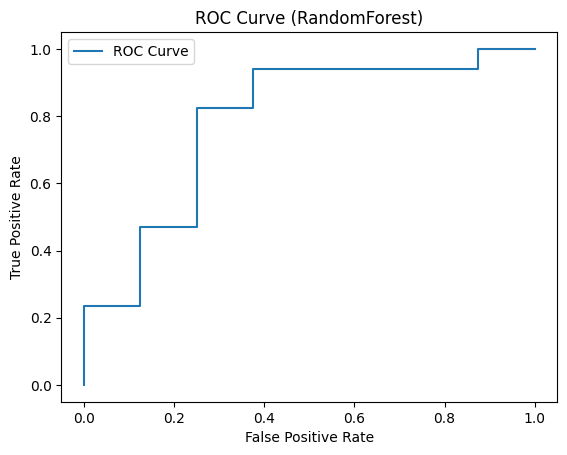

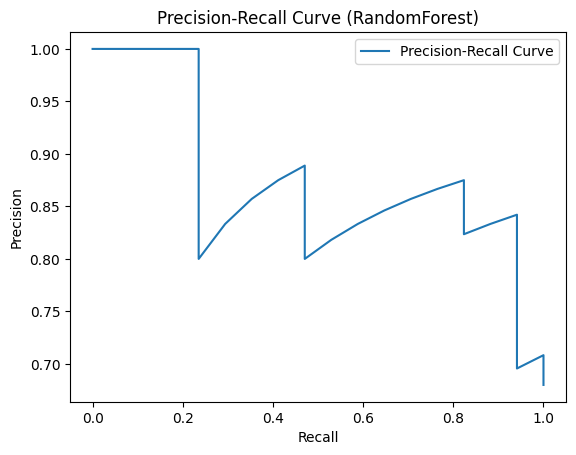

Матрица ошибок (RandomForest):
[[ 1  7]
 [ 1 16]]

Предсказанные активные молекулы (SMILES) для RandomForest:
['COc1cc(/C=C/C(=O)c2cc(OC)c(OCc3cc(OC)c(OC)c(OC)c3)c(OC)c2)cc(OC)c1OC', 'COc1cc(/C=C/C(=O)c2cc(OC)c(OCc3ccccc3)c(OC)c2)cc(Br)c1OC', 'COc1ccc(-c2cccs2)cc1/C=C/C(=O)c1ccc(OC)c(OC)c1', 'COc1ccc(-c2cccs2)cc1/C=C/C(=O)c1ccc(OCc2cccnc2)c(OC)c1', 'COc1ccc(/C=C/C(=O)c2cc(C(C)(C)C)c(O)c(C(C)(C)C)c2)cc1', 'CCN1C(=O)c2cc3c(OC)cc(OCC(=O)OC(C)(C)C)cc3n2C1=S', 'COc1ccc(-c2cccs2)cc1/C=C/C(=O)c1ccc(OCc2ccccn2)c(OC)c1', 'COc1cc(OC)c2cc3n(c2c1)C(=S)N(CCc1ccccc1)C3=O', 'COc1cc(/C=C/C(=O)c2ccc3c(c2)OC(O)(O)O3)cc(-c2cccs2)c1OC', 'COc1cc(OC)c(-c2cc3ccccc3s2)cc1/C=C/C(=O)c1ccc(OC)c(OC)c1OC', 'Cc1cc2occ(CN(C)CCN(C)Cc3cn(-c4cccc(C(F)(F)F)c4)c4ccccc34)c(=O)c2cc1C', 'COc1ccc(C(=O)/C=C/c2ccc(-c3cccs3)cc2)cc1OC', 'COc1cc(OC)c2cc3n(c2c1)C(=S)N(CCCN1CCOCC1)C3=O', 'COc1cc(OC)c(C(=O)/C=C/c2cc(-c3cccs3)ccc2OC)c(OC)c1', 'COc1cc(OC)c(-c2cc3ccccc3s2)cc1/C=C/C(=O)c1cc(OC)c(O)c(OC)c1', 'COc1ccc(/C=C/C(=O)c2cc(C(C)(

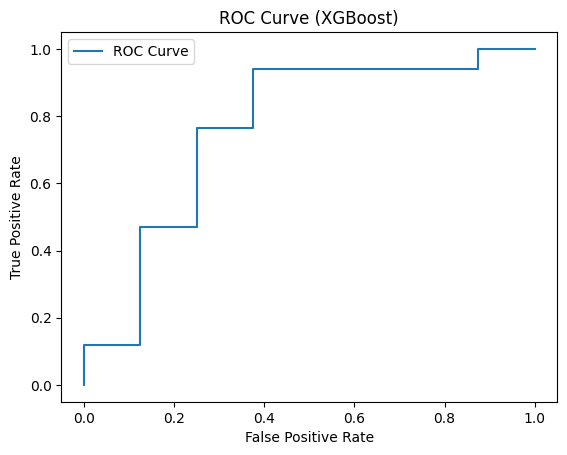

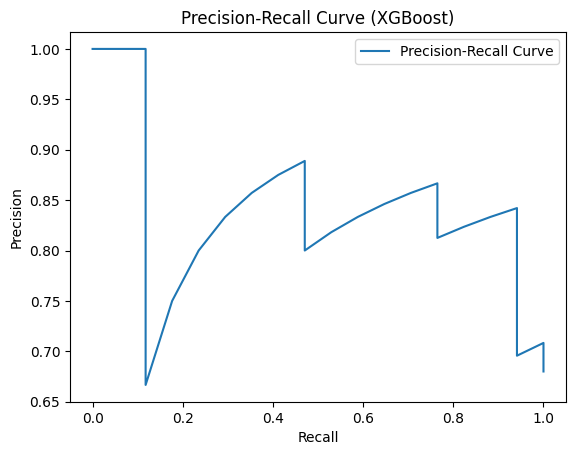

Матрица ошибок (XGBoost):
[[ 3  5]
 [ 1 16]]

Предсказанные активные молекулы (SMILES) для XGBoost:
['COc1cc(/C=C/C(=O)c2cc(OC)c(OCc3cc(OC)c(OC)c(OC)c3)c(OC)c2)cc(OC)c1OC', 'COc1cc(/C=C/C(=O)c2cc(OC)c(OCc3ccccc3)c(OC)c2)cc(Br)c1OC', 'COc1ccc(-c2cccs2)cc1/C=C/C(=O)c1ccc(OC)c(OC)c1', 'COc1ccc(-c2cccs2)cc1/C=C/C(=O)c1ccc(OCc2cccnc2)c(OC)c1', 'CCN1C(=O)c2cc3c(OC)cc(OCC(=O)OC(C)(C)C)cc3n2C1=S', 'COc1ccc(-c2cccs2)cc1/C=C/C(=O)c1ccc(OCc2ccccn2)c(OC)c1', 'COc1cc(OC)c2cc3n(c2c1)C(=S)N(CCc1ccccc1)C3=O', 'COc1cc(/C=C/C(=O)c2ccc3c(c2)OC(O)(O)O3)cc(-c2cccs2)c1OC', 'COc1cc(OC)c(-c2cc3ccccc3s2)cc1/C=C/C(=O)c1ccc(OC)c(OC)c1OC', 'Cc1cc2occ(CN(C)CCN(C)Cc3cn(-c4cccc(C(F)(F)F)c4)c4ccccc34)c(=O)c2cc1C', 'COc1ccc(C(=O)/C=C/c2ccc(-c3cccs3)cc2)cc1OC', 'COc1cc(OC)c2cc3n(c2c1)C(=S)N(CCCN1CCOCC1)C3=O', 'COc1cc(OC)c(C(=O)/C=C/c2cc(-c3cccs3)ccc2OC)c(OC)c1', 'COc1cc(OC)c(-c2cc3ccccc3s2)cc1/C=C/C(=O)c1cc(OC)c(O)c(OC)c1', 'COc1ccc(/C=C/C(=O)c2cc(C(C)(C)C)c(OC)c(C(C)(C)C)c2)cc1', 'CCN1C(=O)C(=Cc2c[nH]c3ccc([N+](=O)[O-

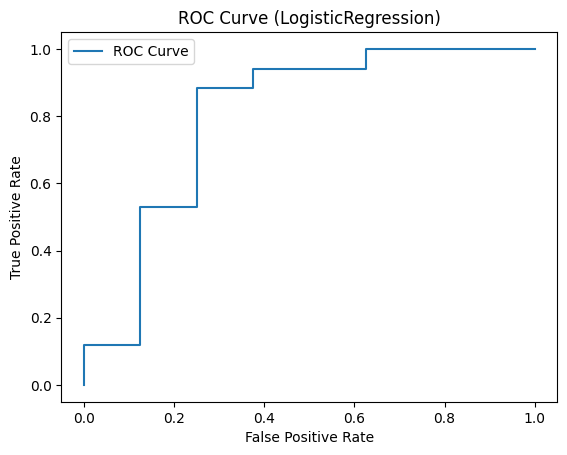

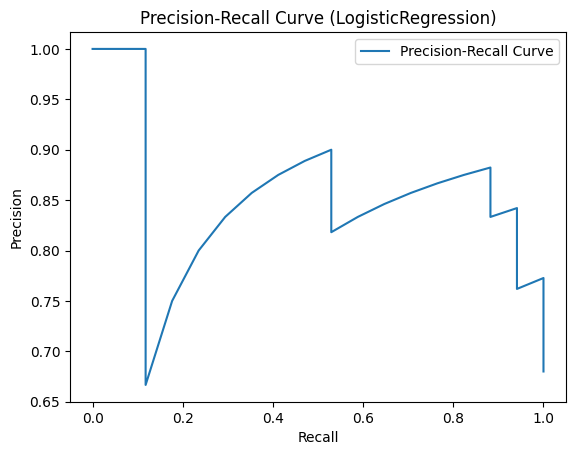

Матрица ошибок (LogisticRegression):
[[ 4  4]
 [ 1 16]]

Предсказанные активные молекулы (SMILES) для LogisticRegression:
['COc1cc(/C=C/C(=O)c2cc(OC)c(OCc3cc(OC)c(OC)c(OC)c3)c(OC)c2)cc(OC)c1OC', 'COc1cc(/C=C/C(=O)c2cc(OC)c(OCc3ccccc3)c(OC)c2)cc(Br)c1OC', 'COc1ccc(-c2cccs2)cc1/C=C/C(=O)c1ccc(OC)c(OC)c1', 'COc1ccc(-c2cccs2)cc1/C=C/C(=O)c1ccc(OCc2cccnc2)c(OC)c1', 'CCN1C(=O)c2cc3c(OC)cc(OCC(=O)OC(C)(C)C)cc3n2C1=S', 'COc1ccc(-c2cccs2)cc1/C=C/C(=O)c1ccc(OCc2ccccn2)c(OC)c1', 'COc1cc(OC)c2cc3n(c2c1)C(=S)N(CCc1ccccc1)C3=O', 'COc1cc(/C=C/C(=O)c2ccc3c(c2)OC(O)(O)O3)cc(-c2cccs2)c1OC', 'COc1cc(OC)c(-c2cc3ccccc3s2)cc1/C=C/C(=O)c1ccc(OC)c(OC)c1OC', 'COc1ccc(C(=O)/C=C/c2ccc(-c3cccs3)cc2)cc1OC', 'COc1cc(OC)c2cc3n(c2c1)C(=S)N(CCCN1CCOCC1)C3=O', 'COc1cc(OC)c(C(=O)/C=C/c2cc(-c3cccs3)ccc2OC)c(OC)c1', 'COc1cc(OC)c(-c2cc3ccccc3s2)cc1/C=C/C(=O)c1cc(OC)c(O)c(OC)c1', 'CCN1C(=O)C(=Cc2c[nH]c3ccc([N+](=O)[O-])cc23)C(=O)N(CC)C1=S', 'COc1ccc(-c2cccs2)cc1/C=C/C(=O)c1cc(OC)c(OCC(=O)O)c(OC)c1', 'O=C(N/N=C/c1cc(C(=O)O)c

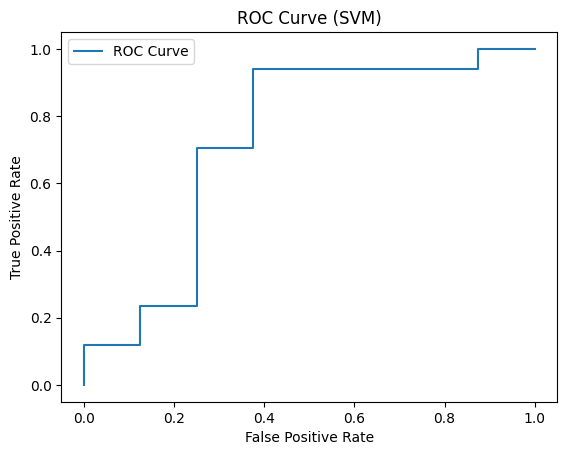

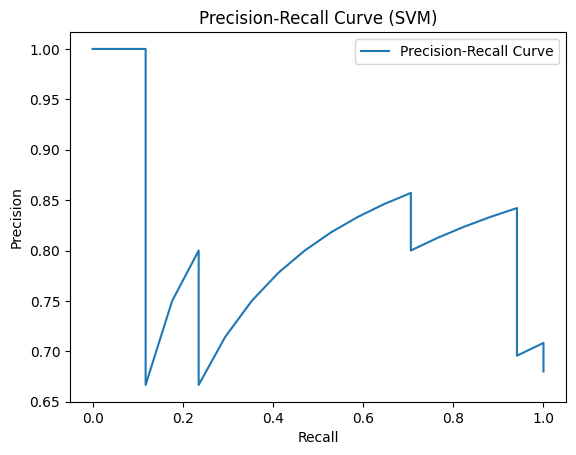

Матрица ошибок (SVM):
[[ 1  7]
 [ 0 17]]

Предсказанные активные молекулы (SMILES) для SVM:
['COc1cc(/C=C/C(=O)c2cc(OC)c(OCc3cc(OC)c(OC)c(OC)c3)c(OC)c2)cc(OC)c1OC', 'COc1cc(/C=C/C(=O)c2cc(OC)c(OCc3ccccc3)c(OC)c2)cc(Br)c1OC', 'COc1ccc(-c2cccs2)cc1/C=C/C(=O)c1ccc(OC)c(OC)c1', 'COc1ccc(-c2cccs2)cc1/C=C/C(=O)c1ccc(OCc2cccnc2)c(OC)c1', 'COc1ccc(/C=C/C(=O)c2cc(C(C)(C)C)c(O)c(C(C)(C)C)c2)cc1', 'CCN1C(=O)c2cc3c(OC)cc(OCC(=O)OC(C)(C)C)cc3n2C1=S', 'COc1ccc(-c2cccs2)cc1/C=C/C(=O)c1ccc(OCc2ccccn2)c(OC)c1', 'COc1cc(OC)c2cc3n(c2c1)C(=S)N(CCc1ccccc1)C3=O', 'COc1cc(/C=C/C(=O)c2ccc3c(c2)OC(O)(O)O3)cc(-c2cccs2)c1OC', 'COc1cc(OC)c(-c2cc3ccccc3s2)cc1/C=C/C(=O)c1ccc(OC)c(OC)c1OC', 'Cc1cc2occ(CN(C)CCN(C)Cc3cn(-c4cccc(C(F)(F)F)c4)c4ccccc34)c(=O)c2cc1C', 'COc1ccc(C(=O)/C=C/c2ccc(-c3cccs3)cc2)cc1OC', 'COc1cc(OC)c2cc3n(c2c1)C(=S)N(CCCN1CCOCC1)C3=O', 'COc1cc(OC)c(C(=O)/C=C/c2cc(-c3cccs3)ccc2OC)c(OC)c1', 'COc1cc(OC)c(-c2cc3ccccc3s2)cc1/C=C/C(=O)c1cc(OC)c(O)c(OC)c1', 'COc1ccc(/C=C/C(=O)c2cc(C(C)(C)C)c(OC)c(C(C)(C)

In [18]:
# список моделей для анализа
models = {
    'RandomForest': models['RandomForest'],  # Предполагается, что models уже определен
    'XGBoost': models['XGBoost'],
    'LogisticRegression': models['LogisticRegression'],
    'SVM': models['SVM']
}

# Цикл по всем моделям
for name, model in models.items():
    # Предсказания
    y_pred = model.predict(X_test)

    # Проверка, поддерживает ли модель predict_proba
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        # Для SVM, если probability=False, используем decision_function
        y_pred_proba = model.decision_function(X_test)

    # 1. ROC-кривая
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({name})')
    plt.legend()
    plt.show()

    # 2. Precision-Recall кривая
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(recall, precision, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ({name})')
    plt.legend()
    plt.show()

    # 3. Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    print(f"Матрица ошибок ({name}):")
    print(cm)

    # 4. Предсказанные активные молекулы
    active_indices = X_test.index[y_pred == 1]
    active_molecules = df.loc[active_indices, 'canonical_smiles']
    print(f"\nПредсказанные активные молекулы (SMILES) для {name}:")
    print(active_molecules.tolist())

Анализ матрицы ошибок для Random Forest.
True Positives (TP): 16 — модель правильно классифицировала 16 активных молекул.
False Positives (FP): 7 — 7 неактивных молекул ошибочно классифицированы как активные.
False Negatives (FN): 1 — 1 активная молекула пропущена.
True Negatives (TN): 1 — только 1 неактивная молекула правильно классифицирована.

Модель хорошо справляется с выявлением активных молекул (высокий Recall),
но допускает ложноположительные результаты (низкий Precision для неактивных).

Random Forest эффективно предсказывает активные молекулы (высокий Recall),
но из-за небольшого размера данных (125 молекул) и дисбаланса классов
 (93 активных против 32 неактивных) модель склонна переоценивать активность.

RandomForest имеет наименьшее количество FN (1), что делает его лучшим для поиска
 активных молекул. Однако большое количество FP (7) снижает точность.
 LogisticRegression лучше балансирует классы, но пропускает больше активных молекул.

 Итак: На основании анализа ROC-кривых, Precision-Recall кривых и матриц ошибок можно
сделать следующие выводы. RandomForest демонстрирует лучшие результаты среди всех
моделей. XGBoost и SVM показывают схожие результаты.
Все модели склонны к переоценке активности молекул (высокий Recall, низкий Precision),
что, вероятно, связано с дисбалансом классов в данных (больше активных молекул,
чем неактивных). Ни одна модель не достигает высокой точности (AUC > 0.9),
что указывает на ограничения текущего набора данных или подхода к обучению.
